In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

# 1 The Quantum Teleportation Protocol
https://qiskit.org/textbook/ch-algorithms/teleportation.html

In [37]:
def create_bell_pair(qc, a, b):
    '''create a bell pair in qc using qubits a & b
    '''
    qc.h(a)
    qc.cx(a, b)

## Step 1: A third party (Telamon) creates entangled qubits q1 and q2 and gives to Alice and Bob respectively

In [51]:
# some resigters form a circuit
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)
qc.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

##  Step 2: Alice applies a CNOT gate to q1, controlled by ket psi (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to ket psi.

In [43]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [47]:
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)

# step 2
qc.barrier()
alice_gates(qc, 0, 1)
qc.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

## Step 3: Alice applies a measurement to both qubits that she owns, q1 and ket psi and stores this result in two classical bits. She then sends these two bits to Bob

In [49]:
def measure_and_send(qc, a, b):
    '''Measures qubits a & b and 'sends' the results to Bob
    '''
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)

In [50]:
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)

# step 2
qc.barrier()
alice_gates(qc, 0, 1)

# step 3
measure_and_send(qc, 0, 1)
qc.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

## Step 4: Bob, who already has the qubit q2, then applies the following gates depending on the state of the classical bits

In [83]:
def bob_gates(qc, qubit, crz, crx):
    qc.z(qubit).c_if(crz, 1) # apply gates if the registers are in the state 1
    qc.x(qubit).c_if(crx, 1)

In [84]:
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)

# step 2
qc.barrier()
alice_gates(qc, 0, 1)

# step 3
measure_and_send(qc, 0, 1)

# step 4
qc.barrier()
bob_gates(qc, 2, crz, crx)
qc.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ Z ├──┤ X ├─
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                  ║  ║    ┌──┴──┐   │   
crz: 1/═══════════════════════════╩══╬════╡ = 1 ╞═══╪═══
                                  0  ║    └─────┘┌──┴──┐
crx: 1/══════════════════════════════╩═══════════╡ = 1 ╞
                                     0           └─────┘

# 2 Simulating the Teleportation Protocol

## 2.1 Using the Statevector Simulator

<IPython.core.display.Math object>

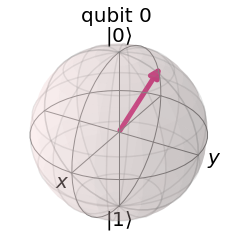

In [2]:
psi = random_state(1)
array_to_latex(psi, pretext="|\\psi\\rangle =")
plot_bloch_multivector(psi)

In [6]:
print(psi[0])
print(psi[0].conjugate())

(0.5654834928195972+0.6532721258232275j)
(0.5654834928195972-0.6532721258232275j)


In [3]:
float(psi[0].conjugate() * psi[0]) + float(psi[1].conjugate() * psi[1])

<ipython-input-3-6f49d5a1f70d>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  float(psi[0].conjugate() * psi[0]) + float(psi[1].conjugate() * psi[1])


0.9999999999999998

In [20]:
a = 0.27340268
b = 0.93655612
c = 0.03673309
d = 0.21625053
print(a ** 2 + b ** 2 + c ** 2 + d ** 2)

1.0000000029668659


---

<IPython.core.display.Math object>

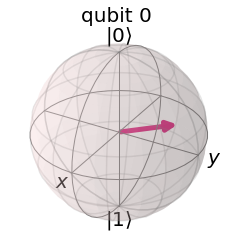

In [88]:
psi = random_state(1)
array_to_latex(psi, pretext="|\\psi\\rangle =")
plot_bloch_multivector(psi)

In [89]:
init_gate = Initialize(psi)
init_gate.label = "init"

qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 0： initialize Alice's q0
qc.append(init_gate, [0])  # set Alice to psi
qc.barrier()

# step 1: begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

# step 2: send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

# step 3: 
measure_and_send(qc, 0, 1)

# step 4
qc.barrier()
bob_gates(qc, 2, crz, crx)  # now psi is teleported to Bob
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐    ░               
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├────░───────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──░──┤ Z ├──┤ X ├─
                ░      └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                             ║  ║    ┌──┴──┐   │   
crz: 1/══════════════════════════════════════╩══╬════╡ = 1 ╞═══╪═══
                                             0  ║    └─────┘┌──┴──┐
crx: 1/═════════════════════════════════════════╩═══════════╡ = 1 ╞
                                                0           └─────┘

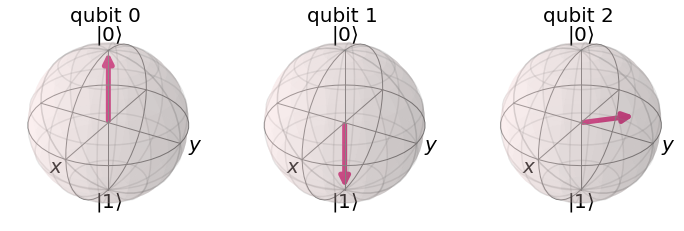

In [90]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

# qubit 2 is the same as the psi = random_state(1)

## 2.2 Using the QASM Simulator

In [96]:
init_gate = Initialize(psi)
init_gate.label = "init"
inverse_init_gate = init_gate.gates_to_uncompute()

# setup
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 0： initialize Alice's q0
qc.append(init_gate, [0])  # set Alice to psi
qc.barrier()

# step 1: begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

# step 2: send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

# step 3: Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

# step 4: Bob decodes qubits
bob_gates(qc, 2, crz, crx)  # now psi is teleported to Bob

# step 5: reverse the initialization process
qc.append(inverse_init_gate, [2])
qc.draw()


┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ Z ├──┤ X ├─»
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ »
                                             ║  ║ ┌──┴──┐   │   »
crz: 1/══════════════════════════════════════╩══╬═╡ = 1 ╞═══╪═══»
                                             0  ║ └─────┘┌──┴──┐»
crx: 1/═════════════════════════════════════════╩════════╡ = 1 ╞»
                                                0        └─────┘»
«                       
«  q_0: ────────────────
«                       
«  q_1: ────────────────
«       ┌──────────────┐
«  q_2: ┤ disentangler ├
«       └──────────────┘
«crz: 1/════════════════
«                       
«crx: 1/════════════════
«

In [97]:
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2, 2)
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ Z ├──┤ X ├─»
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ »
                                             ║  ║ ┌──┴──┐   │   »
crz: 1/══════════════════════════════════════╩══╬═╡ = 1 ╞═══╪═══»
                                             0  ║ └─────┘┌──┴──┐»
crx: 1/═════════════════════════════════════════╩════════╡ = 1 ╞»
                                                0        └─────┘»
 c1: 1/═════════════════════════════════════════════════════════»
                                                                »
«                          
«  q_0: ───────────────────
«                          
«  q_1: ───────────────────
«       ┌──────────────┐┌─┐
«  q_2: ┤ disentangler ├┤M├
«       └──────────────┘└╥┘
«crz: 1/═════════════════╬═
«                        ║ 
«crx: 1/═════════════════╬═
«                        ║ 
« c1: 1/═════════════════╩═
«                        0

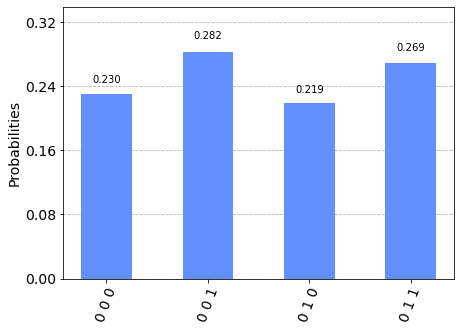

In [98]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [99]:
0.23 + 0.282 + 0.219 + 0.269

1.0